## Телеком. Прогнозирование оттока клиентов в компании "Ниединогоразрыва.ком". 

Заказчиком поставлена задача написать по имеющимся в компании данных модель предсказания оттока клиентов. 

Предоставлены следующие данные: 4 таблицы, в каждой из которых зафиксированы ID клиента и различные данные о них, пол, набор услуг которыми пользуется клиент, и факт ухода или продолжения сотрудничества с компанией. 

Требуется произвести первичный осмотр качества данных, там, где необходимо - преобработку, и провести тестирование на нескольких алгоритмах машинного обучения, как с бустингом, так и без него. 

Оглавление:

1. Анализ таблиц:

        1.1 Таблица contract
    
        1.2 Таблица internet
    
        1.3 Таблица personal
    
        1.4 Таблица phone
        
2. Промежуточные выводы по таблицам;

3. План работы;

4. Работа с таблицами по объединению и предобработке данных; расчет моделей.

        4.1 Предобработка для моделей без градиентного бустинга
        
        4.2 Обучение и оценка моделей. Решающее дерево
        
        4.3 Обучение и оценка моделей. Случайный лес 
              
        4.4 Предобработка для моделей с градиентным бустингом
        
        4.5 Модель CatboostClassifier
         
        4.6 Модель LGBMClassifier
        
5. Определяем лучшую модель: 
         
         5.1 Расчет AUC-ROC по лучшей модели на тестовой выборке:
         
6. Краткий вывод по работе.

7. Отчет о проделанной работе. 

### 1. Анализ таблиц

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from catboost import cv
from catboost import * 
from catboost import datasets

In [2]:
contract = pd.read_csv('/Users/artem/Desktop/Работы Юпитер/Финальный проект/final_provider/contract.csv')
internet = pd.read_csv('/Users/artem/Desktop/Работы Юпитер/Финальный проект/final_provider/internet.csv')
personal = pd.read_csv('/Users/artem/Desktop/Работы Юпитер/Финальный проект/final_provider/personal.csv')
phone = pd.read_csv('/Users/artem/Desktop/Работы Юпитер/Финальный проект/final_provider/phone.csv')

1.1 Анализируем первую таблицу

In [3]:
contract.info() # предварительно пропусков нет
# в некоторых столбцах тип данных не соответствует предполагаемому содержанию

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
contract.head() # смотрим на данные

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
# смотрим на дубликаты в колонке customerID

print('Количество уникальных ID пользователя = ', len(contract['customerID'].unique()), 'Общее количество значений user ID = ', contract['customerID'].count())

# количество совпадает, дубликатов по user ID нет

Количество уникальных ID пользователя =  7043 Общее количество значений user ID =  7043


In [6]:
# столбец EndDate - наш целевой признак, оценим распределение положительных/отрицательных значений
print(contract.query('EndDate != "No"')['customerID'].count()) # количество ушедших юзеров 1869
print(contract.query('EndDate == "No"')['customerID'].count()) # количество оставшихся пользователей 5174

# подсчитаем отношение к общему количеству
print('Процент ушедших клиентов = ', (contract.query('EndDate != "No"')['customerID'].count()/contract['customerID'].count())*100)
print('Процент оставшихся клиентов = ', (contract.query('EndDate == "No"')['customerID'].count()/contract['customerID'].count())*100)

# количество клиентов,ушедших из компании, почти в 3 раза меньше, чем оставшихся - необходимо будет уравнять данные в небольшое количество раз (1.5-2, чтобы избежать переобучения) в будущем для корректного обучения модели

1869
5174
Процент ушедших клиентов =  26.536987079369588
Процент оставшихся клиентов =  73.4630129206304


In [7]:
contract['PaperlessBilling'].unique() # аномальных значений нет

array(['Yes', 'No'], dtype=object)

In [8]:
contract['PaymentMethod'].unique() # аномальных значений нет

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [9]:
#contract['TotalCharges'].astype('float64') - выдает ошибку, в данных есть или пропуски или буквы
contract.query('TotalCharges < "1"') # видим что есть пропуски, все данные датированы 01 февраля 2020г - поэтому нет базы для расчета общего расхода
# данные стоит привести к цифровому типу, в месте пропусков поставить значение из MonthlyCharges или просто удалить данные, всего 11 строк

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Предварительные выводы по таблице 1: 

Дубликатов или задвоений в базе клиентов нет;

дата BeginDate указана в неправильном формате;

дата EndDate - наш целевой признак, даты стоит заполнить значением "yes" чтобы нормально обучить модель; для экономии памяти можно было бы привести данные столбца к типу категорий;

TotalCharges имеет тип данных объект, хотя должен быть цифровым; есть пропуски из-за клиентов, которые зарегистрировались недавно - их всего 11 штук, можно удалить.

Количество клиентов,ушедших из компании, почти в 3 раза меньше, чем оставшихся - необходимо будет уравнять данные в небольшое количество раз (1.5-2, чтобы избежать переобучения) в будущем для корректного обучения модели;

1.2 Таблица internet

In [10]:
internet.info() # пропусков предварительно нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet['InternetService'].unique() # аномальных значений нет

array(['DSL', 'Fiber optic'], dtype=object)

In [13]:
internet['OnlineSecurity'].unique() # аномальных значений нет

array(['No', 'Yes'], dtype=object)

In [14]:
internet['OnlineBackup'].unique() # аномальных значений нет

array(['Yes', 'No'], dtype=object)

In [15]:
internet['DeviceProtection'].unique() # аномальных значений нет

array(['No', 'Yes'], dtype=object)

In [16]:
internet['TechSupport'].unique() # аномальных значений нет

array(['No', 'Yes'], dtype=object)

In [17]:
internet['StreamingTV'].unique() # аномальных значений нет

array(['No', 'Yes'], dtype=object)

In [18]:
internet['StreamingMovies'].unique() # аномальных значений нет

array(['No', 'Yes'], dtype=object)

Text(0.5, 1.0, 'Распределение DSL и Fiber optic')

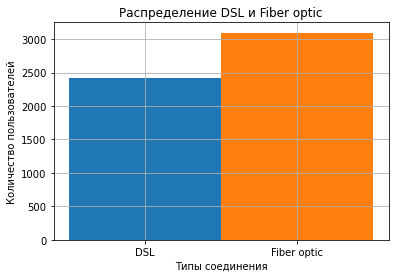

In [19]:
internet.query('InternetService == "DSL"')['InternetService'].hist(bins=1)
internet.query('InternetService == "Fiber optic"')['InternetService'].hist(bins=1)
plt.xlabel('Типы соединения')
plt.ylabel('Количество пользователей')
plt.title('Распределение DSL и Fiber optic')

Text(0.5, 1.0, 'Распределение пользователей услуги OnlineSecurity')

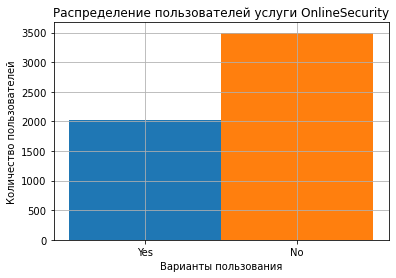

In [20]:
internet.query('OnlineSecurity == "Yes"')['OnlineSecurity'].hist(bins=1)
internet.query('OnlineSecurity == "No"')['OnlineSecurity'].hist(bins=1)
plt.xlabel('Варианты пользования')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей услуги OnlineSecurity')

Text(0.5, 1.0, 'Распределение пользователей услуги OnlineBackup')

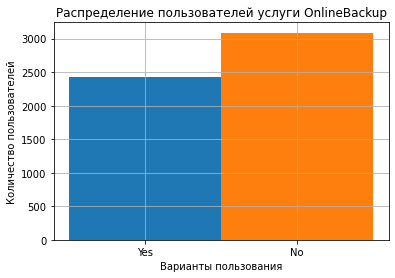

In [21]:
internet.query('OnlineBackup == "Yes"')['OnlineBackup'].hist(bins=1)
internet.query('OnlineBackup == "No"')['OnlineBackup'].hist(bins=1)
plt.xlabel('Варианты пользования')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей услуги OnlineBackup')

Text(0.5, 1.0, 'Распределение пользователей услуги DeviceProtection')

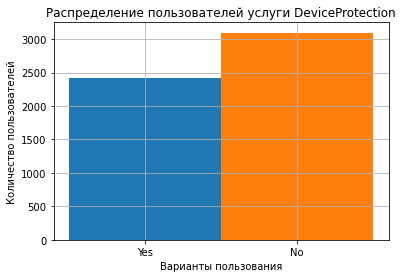

In [22]:
internet.query('DeviceProtection == "Yes"')['DeviceProtection'].hist(bins=1)
internet.query('DeviceProtection == "No"')['DeviceProtection'].hist(bins=1)
plt.xlabel('Варианты пользования')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей услуги DeviceProtection')

Text(0.5, 1.0, 'Распределение пользователей услуги TechSupport')

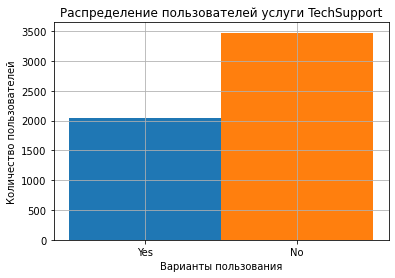

In [23]:
internet.query('TechSupport == "Yes"')['TechSupport'].hist(bins=1)
internet.query('TechSupport == "No"')['TechSupport'].hist(bins=1)
plt.xlabel('Варианты пользования')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей услуги TechSupport')

Text(0.5, 1.0, 'Распределение пользователей с услугой StreamingTV')

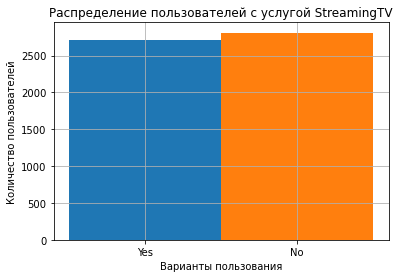

In [24]:
internet.query('StreamingTV == "Yes"')['StreamingTV'].hist(bins=1)
internet.query('StreamingTV == "No"')['StreamingTV'].hist(bins=1)
plt.xlabel('Варианты пользования')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей с услугой StreamingTV')

Text(0.5, 1.0, 'Распределение пользователей с услугой StreamingMovies')

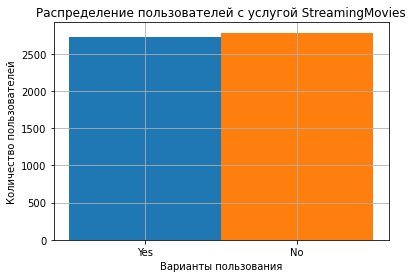

In [25]:
internet.query('StreamingMovies == "Yes"')['StreamingMovies'].hist(bins=1)
internet.query('StreamingMovies == "No"')['StreamingMovies'].hist(bins=1)
plt.xlabel('Варианты пользования')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей с услугой StreamingMovies')

Text(0.5, 1.0, 'Распределение пользователей по типу подключения')

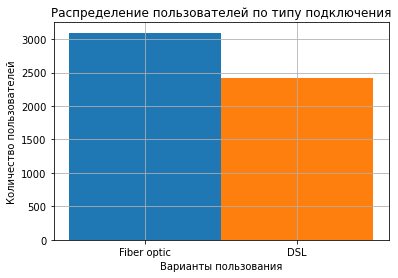

In [26]:
internet.query('InternetService == "Fiber optic"')['InternetService'].hist(bins=1)
internet.query('InternetService == "DSL"')['InternetService'].hist(bins=1)
plt.xlabel('Варианты пользования')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по типу подключения')

Предварительные выводы по таблице 2: 

Данные распределены без явных перекосов, дубликатов нет

1.3 Таблица personal

In [27]:
personal.info() # пропусков предварительно нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


[0 1]


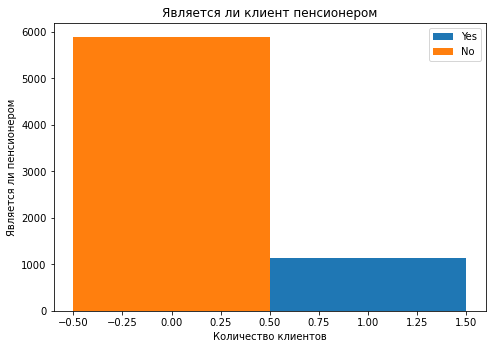

In [28]:
print(personal['SeniorCitizen'].unique()) # аномальных значений нет

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

personal.query('SeniorCitizen == 1')['SeniorCitizen'].plot(kind='hist', bins=1, label='Yes')
personal.query('SeniorCitizen == 0')['SeniorCitizen'].plot(kind='hist', bins=1, label='No')
plt.title('Является ли клиент пенсионером')
plt.xlabel('Количество клиентов')
plt.ylabel('Является ли пенсионером')

ax.legend();

['Female' 'Male']


Text(0.5, 1.0, 'Распределение пользователей по гендеру')

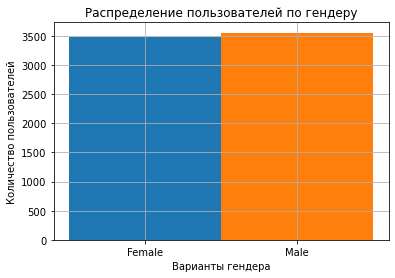

In [29]:
print(personal['gender'].unique()) # аномальных значений нет


personal.query('gender == "Female"')['gender'].hist(bins=1)
personal.query('gender == "Male"')['gender'].hist(bins=1)
plt.xlabel('Варианты гендера')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по гендеру')

In [30]:
personal.query('Partner == "Yes"')['Partner']

0       Yes
8       Yes
10      Yes
12      Yes
15      Yes
       ... 
7031    Yes
7038    Yes
7039    Yes
7040    Yes
7041    Yes
Name: Partner, Length: 3402, dtype: object

['Yes' 'No']


Text(0.5, 1.0, 'Семейный статус клиента')

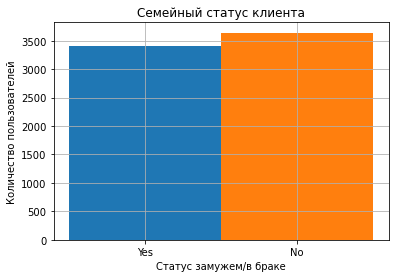

In [31]:
print(personal['Partner'].unique()) # аномальных значений нет

personal.query('Partner == "Yes"')['Partner'].hist(bins=1)
personal.query('Partner == "No"')['Partner'].hist(bins=1)
plt.xlabel('Статус замужем/в браке')
plt.ylabel('Количество пользователей')
plt.title('Семейный статус клиента')

['No' 'Yes']


Text(0.5, 1.0, 'Есть ли иждивенцы в семье')

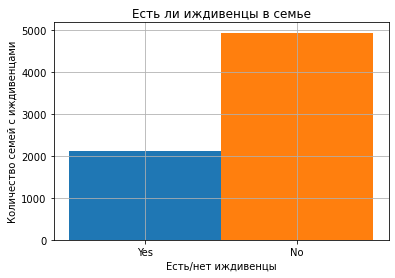

In [32]:
print(personal['Dependents'].unique()) # аномальных значений нет

personal.query('Dependents == "Yes"')['Dependents'].hist(bins=1)
personal.query('Dependents == "No"')['Dependents'].hist(bins=1)
plt.xlabel('Есть/нет иждивенцы')
plt.ylabel('Количество семей с иждивенцами')
plt.title('Есть ли иждивенцы в семье')

Предварительные выводы по таблице 3: 

Есть явные перекосы в столбцах SeniorCitizen и Dependents, скорее всего это будет выравнено в будущем при формировании обучающих выборок 

In [33]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [34]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


['No' 'Yes']


Text(0.5, 1.0, 'Услуга "вторая линия')

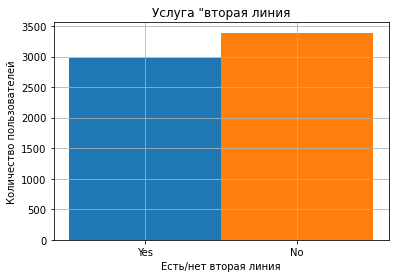

In [35]:
print(phone['MultipleLines'].unique()) # аномальных значений нет

phone.query('MultipleLines == "Yes"')['MultipleLines'].hist(bins=1)
phone.query('MultipleLines == "No"')['MultipleLines'].hist(bins=1)
plt.xlabel('Есть/нет вторая линия')
plt.ylabel('Количество пользователей')
plt.title('Услуга "вторая линия')


### 2. Выводы по таблицам: 

Для получения максимального качества прогноза в будущем хорошо бы через команду merge склеить таблицы в одну;  

(пример: contract.merge(internet, on = ['customerID'], how='outer')). 

Количество значений в таблицах internet и phone не совпадает с общим количеством значений, в связи с чем предполагаю следующее развитие событий:

Таблица phones содержит только такой показатель как MultipleLines, можем предположить, что внутри компании известно, кому она подключена, а кому нет, поэтому недостающие значения будем заполнять как 'No' по-умолчанию. 

Таблица internet содержит большое количество признаков, однако работать предполагаю по тому же принципу, что и с таблицей phones: если в таблице internet отсутствует положительное значение для каждого конкретного ID, то по-умолчанию считаем, что интернет для него не подключен и Nan в смерженной таблице заполняется так же значением 'No'.

### 3. План работы: 

1. Составление единой таблицы признаков через команду merge;
        1.1 Заполнение пропусков через fillna('No') по столбцам где это требуется;
        1.2 Изменение типов данных на категории, чтобы модели могли с ними работать;
        1.3 Работа с другими столбцами - изменение формата дат, удаление дат из столбца EndDate и замена на Yes (чтобы опять же привести к категории). Сюда же, расширенный анализ данных, поиск возможных выбросов по тратам и прочим количественным показателям;
        1.4 Людей, которые зарегистрировались в феврале 2020г - либо удалить, либо заполнить столбец TotalCharges значением из MonthlyCharges - зависит от того, сколько данных есть по этим 11 user ID, если они окажутся полезными - можем использовать в обучении, если по ним нет большого числа признаков - проще удалить; 
        1.5 Проверить корреляцию признаков, есть ли она между признаками;
2. Разделение таблицы на обучающую-валидационную-тестовую выборки и на таблицу признаков-ответов. Целевой показатель - факт ухода клиента.
        2.1 Так как по целевому признаку у нас явный перекос в сторону тех, кто остался, проведем апсемплинг данных чтобы разрыв у положительных-отрицательных "ответов" не был таким большим; если произойдет переобучение - убрать;
        2.2 По итогам поиска корелляции принять решение об удалении каких-то признаков, если такое потребуется; 
3. Метрики качества планирую использовать accuracy_score (для себя) и AUC-ROC (как итоговую метрику). 

### 4. Работа с таблицами по объединению и предобработке данных; расчет моделей.

#### 4.1 Предобработка для моделей без градиентного бустинга

Соединяем отдельные таблицы в одну:

In [36]:
df = contract.merge(internet, on = ['customerID'], how='outer')
df = df.merge(personal, on = ['customerID'], how='outer')
df = df.merge(phone, on = ['customerID'], how='outer')

Проверим как отработались пропуски при склейке: видим nan как третий тип значения, их и будем заменять

In [37]:
df['TechSupport'].unique()

array(['No', 'Yes', nan], dtype=object)

Осмотрим качество склейки и количество пропусков:

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


столбец InternetService заполним тремя категориями: DSL, Fiberoptic и No для тех, у кого интернета нет.


столбец MultipleLines заполняем значением No


список столбцов которые заполняются значением No: OnlineSecurity	OnlineBackup	DeviceProtection	TechSupport	StreamingTV	StreamingMovies MultipleLines

Проверка как все получилось:

In [39]:
df['InternetService'].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

Заполняем пропуски в столбцах:

In [40]:
df[['OnlineSecurity', 'OnlineBackup'
    , 'DeviceProtection', 'TechSupport', 'StreamingTV'
    , 'StreamingMovies', 'MultipleLines', 'InternetService']] = df[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection'
                                                 , 'TechSupport', 'StreamingTV'
                                                 , 'StreamingMovies', 'MultipleLines', 'InternetService']].fillna('No')

In [41]:
print(df['TechSupport'].unique()) # проверка что все получилось
print(df['StreamingTV'].unique())

['No' 'Yes']
['No' 'Yes']


Столбец EndDate - наш целевой признак, даты стоит отдельно сохранить для будущих исследований, а сами значения заполнить значением "yes" чтобы нормально обучить модель:

Сохраним данные по завершенным контрактам и проведем небольшой анализ: 

In [42]:
end_date_df = df.query('EndDate != "No"')

In [43]:
end_date_df['BeginDate'] = pd.to_datetime(end_date_df['BeginDate'], format='%Y-%m-%d')
end_date_df['EndDate'] = pd.to_datetime(end_date_df['EndDate'], format='%Y-%m-%d')

/var/folders/vr/wml9hs7s5wzchnjvgzn6ddjc0000gn/T/ipykernel_29622/372664319.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_date_df['BeginDate'] = pd.to_datetime(end_date_df['BeginDate'], format='%Y-%m-%d')
/var/folders/vr/wml9hs7s5wzchnjvgzn6ddjc0000gn/T/ipykernel_29622/372664319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_date_df['EndDate'] = pd.to_datetime(end_date_df['EndDate'], format='%Y-%m-%d')


Создадим столбик с длиной контракта в днях:

In [44]:
end_date_df['long_contract'] = end_date_df['EndDate'] - end_date_df['BeginDate'] 

/var/folders/vr/wml9hs7s5wzchnjvgzn6ddjc0000gn/T/ipykernel_29622/2393779294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  end_date_df['long_contract'] = end_date_df['EndDate'] - end_date_df['BeginDate']


Оценим распределение данных через describe 

In [45]:
end_date_df['long_contract'].describe()

count                           1869
mean     547 days 08:26:57.977528088
std      594 days 09:21:02.012639248
min                 30 days 00:00:00
25%                 61 days 00:00:00
50%                304 days 00:00:00
75%                883 days 00:00:00
max               2191 days 00:00:00
Name: long_contract, dtype: object

Видим что медиана/среднее находятся рядом, но вот максимум очень сильно удален от третьего квартиля, строим ящик с усами, чтобы понять как распределены значения на графике:

<AxesSubplot:>

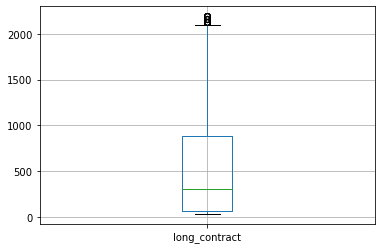

In [46]:
end_date_df['long_contract'].dt.days.reset_index().boxplot(column=['long_contract']) 

Оценим количество значений больше 1000 дней: 

In [47]:
print('Количество расторгнутых контактов сроком до 1000 дней:', end_date_df['long_contract'].dt.days.reset_index().query('long_contract < 1000')['long_contract'].count())
print('Количество расторгнутых контактов сроком свыше 1000 дней:', end_date_df['long_contract'].dt.days.reset_index().query('long_contract > 1000')['long_contract'].count())
print('Количество расторгнутых контактов сроком свыше 1000 дней:', end_date_df['long_contract'].dt.days.reset_index().query('long_contract > 2000')['long_contract'].count())

Количество расторгнутых контактов сроком до 1000 дней: 1460
Количество расторгнутых контактов сроком свыше 1000 дней: 409
Количество расторгнутых контактов сроком свыше 1000 дней: 63


По графику видим что нижний/верхний квартили лежат в промежутке от ~50 до ~900 дней. Так же есть небольшое количество выбросов свыше примерно 2100 дней. Это же подтверждают цифры - выше 2000 всего 63 значения, в то время как больше 1000 - 409. 

Заполняем даты словом Yes:

In [48]:
df.loc[(df['EndDate'] != "No"), 'EndDate'] = "Yes"

Кодируем данные чтобы модель их понимала:

In [49]:
df.loc[(df['EndDate'] == "No"), 'EndDate'] = 0
df.loc[(df['EndDate'] == "Yes"), 'EndDate'] = 1
df['EndDate'] = df['EndDate'].astype('int64')

Удаляем ячейки с пользователями, зарегистрированными в феврале 2020г, чтобы избежать заполнения ячеек в стоблце TotalCharges возможно некорретными данными.

In [50]:
df = df.drop(df.query('TotalCharges < "1"').index, axis=0)

Сформируем перечень столбцов-категорий для кодирования. 

In [52]:
# отделяем признаки от ответов

x = df.drop(['EndDate', 'BeginDate', 'customerID'], axis=1)
y = df['EndDate']

# разбиваем на выборки:
xf_train, xf_test, yf_train, yf_test = train_test_split(x,y, test_size=0.25, random_state=120922)

# проверка размерностей
print(xf_train.shape, yf_train.shape)
print(xf_test.shape, yf_test.shape)

(5274, 17) (5274,)
(1758, 17) (1758,)


Кодируем данные энкодером:

In [53]:
col_list_categ = ['PaperlessBilling', 'OnlineSecurity'
, 'OnlineBackup', 'DeviceProtection', 'TechSupport'
, 'StreamingTV', 'StreamingMovies', 'Partner'
, 'Dependents', 'MultipleLines', 'InternetService', 'gender', 'Type', 'PaymentMethod']

enc = OrdinalEncoder()
enc.fit(xf_train[col_list_categ])
xf_train[col_list_categ] = enc.transform(xf_train[col_list_categ])
xf_test[col_list_categ] = enc.transform(xf_test[col_list_categ])

Масштабируем данные:

In [54]:
numeric = ['MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
scaler.fit(xf_train[numeric])
xf_train[numeric] = scaler.transform(xf_train[numeric])
xf_test[numeric] = scaler.transform(xf_test[numeric])
pd.options.mode.chained_assignment = None

#### 4.2 Обучение и оценка моделей. Решающее дерево

Создадим словарик для хранения результатов работы моделей и последующего отбора лучшей по метрике качества:

In [55]:
result = {}

Отберем лучшие параметры для модели:

In [56]:
model_dt = DecisionTreeClassifier()

parameters = { 
            "max_depth": range(1,10)
}
grid = GridSearchCV(model_dt, parameters, cv=10, scoring='roc_auc') # добавлен скоринг по roc-auc
grid.fit(xf_train, yf_train)
grid.best_params_

{'max_depth': 5}

In [57]:
model_dt = DecisionTreeClassifier(max_depth=grid.best_params_['max_depth'], class_weight='balanced', random_state = 120922)
model_dt.fit(xf_train, yf_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                       random_state=120922)

Расчет accuracy и средней точности модели:

In [58]:
scores = cross_val_score(model_dt, xf_train, yf_train, cv=10, scoring='roc_auc')
final_score_model_dt = scores.mean()
print('Средняя точность DecisionTreeClassifier на метрике roc_auc:', final_score_model_dt)
result['DecisionTreeClassifier'] = final_score_model_dt # записываем значения в словарик

Средняя точность DecisionTreeClassifier на метрике roc_auc: 0.8190106087035239


#### 4.3 Обучение и оценка моделей. Случайный лес

Как и в прошлый раз, через грид ищем лучшие параметры:

In [59]:
model_rf = RandomForestClassifier()

parameters = { "n_estimators" : range(1,11),
            "max_depth": range(1,11)
}
grid = GridSearchCV(model_rf, parameters, cv=10, scoring='roc_auc') # перезаписываем грид, он нам дальше не будет нужен
grid.fit(xf_train, yf_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(1, 11),
                         'n_estimators': range(1, 11)},
             scoring='roc_auc')

In [61]:
model_rf = grid.best_estimator_
scores = cross_val_score(model_rf, xf_train, yf_train, cv=10, scoring='roc_auc')
final_score_model_rf = scores.mean()
print('Средняя точность RandomForestClassifier на метрике roc_auc:', final_score_model_rf)
result['RandomForestClassifier'] = final_score_model_rf

Средняя точность RandomForestClassifier на метрике roc_auc: 0.8385133537615307


#### 4.4 Предобработка для моделей с градиентным бустингом

Создадим копию исходного датафрейма. Нужно для корректной обработки данных для моделей с градиентным бустингом.



In [62]:
ds = contract.merge(internet, on = ['customerID'], how='outer')
ds = ds.merge(personal, on = ['customerID'], how='outer')
ds = ds.merge(phone, on = ['customerID'], how='outer')

In [63]:
ds['TechSupport'].unique() 

array(['No', 'Yes', nan], dtype=object)

Видим 'nan' как третий тип значения, их и будем заменять

Заполним текстом 'No' все образовавшиеся от склейки пропуски (как в части про простые модели):

In [64]:
ds[['OnlineSecurity', 'OnlineBackup'
    , 'DeviceProtection', 'TechSupport'
    , 'StreamingTV', 'StreamingMovies'
    , 'MultipleLines', 'InternetService']] = ds[['OnlineSecurity', 'OnlineBackup'
                              , 'DeviceProtection', 'TechSupport'
                              , 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'InternetService']].fillna('No')

Удаляем столбец user ID, он не является признаком и не нужен в работе модели

In [65]:
ds = ds.drop(['customerID'], axis=1) 

Меняем формат даты

In [66]:
ds['BeginDate'] = pd.to_datetime(ds['BeginDate'], format='%Y-%m-%d')

Форматируем даты столбца EndDate в категориальный признак:

In [67]:
ds.loc[(ds['EndDate'] != "No"), 'EndDate'] = "Yes"

In [68]:
# кодируем и конвертируем данные столбца EndDate
# если этого не сделать, то не будет работать catboost и не будет корректно строиться график AUC-ROC - ему нужны числовые значения
ds.loc[(ds['EndDate'] == "No"), 'EndDate'] = 0
ds.loc[(ds['EndDate'] == "Yes"), 'EndDate'] = 1
ds['EndDate'] = ds['EndDate'].astype('int64')

Создаем список колонок для трансформации:

In [69]:
# EndDate не добавляем, иначе не работает catboost
col_list = ['OnlineSecurity', 'OnlineBackup'
            , 'DeviceProtection', 'TechSupport'
            , 'StreamingTV', 'StreamingMovies'
            , 'MultipleLines', 'PaperlessBilling'
            , 'gender', 'Partner'
            , 'Dependents', 'Type'
            , 'PaymentMethod', 'InternetService', 'SeniorCitizen']

Создаем список столбцов-категорий:

In [70]:
ds[col_list] = ds[col_list].astype('category')

Удалим строки с регистрациями в февраля 2020 года, конвертируем столбец TotalCharges: 

In [71]:
ds = ds.drop(ds.query('TotalCharges < "1"').index, axis=0)
ds['TotalCharges'] = ds['TotalCharges'].astype('float64')

Создаем тренировочные-тестовые выборки: 

In [73]:
# удаляем столбец BeginDate как ненужный
x = ds.drop(['EndDate', 'BeginDate'], axis=1)
y = ds['EndDate']

# разбиваем на выборки:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=120922)

print('Проверка размерностей:')
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

Проверка размерностей:
(5274, 17) (5274,)
(1758, 17) (1758,)


Масштабируем данные:



In [74]:
numeric = ['MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
scaler.fit(x_train[numeric])
x_train[numeric] = scaler.transform(x_train[numeric])
x_test[numeric] = scaler.transform(x_test[numeric])
pd.options.mode.chained_assignment = None

Формируем перечень категориальных признаков для моделей

In [75]:
caterigorial_df = []
for i in ds.columns.tolist():
    if ds[i].dtypes == 'category':
        ds[i] = ds[i].astype('object')        
        caterigorial_df.append(ds[i].name)

print(caterigorial_df) # проверка результата

['Type', 'PaperlessBilling', 'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines']


<div class="alert alert-warning">
    <h2> Комментарий тимлида v3 <a class="tocSkip"> </h2>
<hr>    
<b>Совет💡:</b> А зачем до этого в category переводили, а сейчас отдельно в object?
        
<code>caterigorial_df.append(ds[i].name)</code> почему сразу не складывать содержимое переменной i?
</div></div>

#### 4.4 Модель CatboostClassifier

Настройка и обучение модели: 

In [76]:
%%time
1+1 # определяем время выполнения кода

cat = CatBoostClassifier(cat_features=caterigorial_df)

parameters = { "n_estimators" : range(100,1500,100),
            "depth": range(1,10), 
              'learning_rate': (0.01, 0.7, 0.02)
             }
                   
Grid_CBC = GridSearchCV(estimator=cat, param_grid = parameters, cv = 2, n_jobs=-1, verbose=False, scoring='roc_auc')
Grid_CBC.fit(x_train, y_train, verbose=False) # критически важно указывать False, иначе лог сжирает кучу места

CPU times: user 5.53 s, sys: 1.78 s, total: 7.3 s
Wall time: 6min


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fdcaa80bcd0>,
             n_jobs=-1,
             param_grid={'depth': range(1, 10),
                         'learning_rate': (0.01, 0.7, 0.02),
                         'n_estimators': range(100, 1500, 100)},
             scoring='roc_auc', verbose=False)

In [77]:
Grid_CBC.best_params_

{'depth': 2, 'learning_rate': 0.02, 'n_estimators': 1100}

In [78]:
%%time
1+1 # определяем время выполнения кода
cat = CatBoostClassifier(learning_rate=Grid_CBC.best_params_['learning_rate']
                         , eval_metric='AUC'
                         , n_estimators=Grid_CBC.best_params_['n_estimators']
                         , depth=Grid_CBC.best_params_['depth'])
cat.fit(x_train, y_train, verbose=False, cat_features=caterigorial_df)

CPU times: user 3.49 s, sys: 1.44 s, total: 4.93 s
Wall time: 1.82 s


Дописываем кросс-валидацию к catboost с учетом полученных параметров в гридсерч:

In [79]:
params = {
    'loss_function': 'Logloss',
    'learning_rate': Grid_CBC.best_params_['learning_rate'], 
     'eval_metric':'AUC', 
     'n_estimators': Grid_CBC.best_params_['n_estimators'], 
      'depth': Grid_CBC.best_params_['depth']
}

cv_data = cv(
    params=params,
    pool=Pool(x_train, label=y_train, cat_features=caterigorial_df), # категориальные признаки по списку
    fold_count=10,
    stratified=True, 
    verbose=False,
    shuffle=True
)

final_score_cat = cv_data['test-AUC-mean'].mean()
print('Средняя точность CatBoostClassifier на метрике roc_auc:', final_score_cat)
result['CatBoostClassifier'] = final_score_cat # записываем в словарик результат 

Средняя точность CatBoostClassifier на метрике roc_auc: 0.8432099121262236


#### 4.5 Модель LGBMClassifier

Настраиваем параметры модели:

In [80]:
param_grid =   {
    'n_estimators' : [100, 1000, 100],
    'boosting_type': ['gbdt'],
    'num_leaves': [10, 60, 10],
    'bagging_freq' : [1], # без этих параметров модель выдает ошибку !
    'bagging_fraction': [0.6] # без этих параметров модель выдает ошибку !
}

lgb = LGBMClassifier(random_state=120922, early_stopping_rounds = 10, eval_metric  = 'auc', verbose_eval=20)

grid_search = GridSearchCV(lgb, param_grid=param_grid, scoring='roc_auc',cv=5,n_jobs=-1,verbose=False)

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train,
    y_train,
    test_size=0.1,
    random_state=120922
) # без параметра eval_set эта модель не запускается, создадим валидационную выборку через train_test_split
                                 

In [81]:
grid_search.fit(x_train, y_train, eval_set = (x_valid, y_valid), verbose=False)

best_model = grid_search.best_params_

/Users/artem/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/artem/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/artem/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/artem/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alia

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


Обучаем модель:

In [82]:
%%time
1 + 1
rf = LGBMClassifier(
            boosting_type='gbdt', nthread=4, #rt = 0.8514, gbdt = 0.8476, dart = 0.8511
            n_estimators= grid_search.best_params_['n_estimators'],learning_rate=0.005,
            num_leaves= grid_search.best_params_['num_leaves'],colsample_bytree= 0.8,
            subsample= 0.4,subsample_freq=1,
            max_depth= 30,reg_alpha= 0.5,
            reg_lambda=0.5,min_split_gain=0.04,
            min_child_weight=.05,random_state=0,
            silent=-1,verbose=-1)

rf.fit(x_train, y_train, eval_metric= 'auc', eval_set = [(x_valid, y_valid)], verbose=False, early_stopping_rounds= 200)

/Users/artem/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/artem/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


CPU times: user 1.82 s, sys: 633 ms, total: 2.46 s
Wall time: 715 ms


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.005, max_depth=30,
               min_child_weight=0.05, min_split_gain=0.04, nthread=4,
               num_leaves=10, random_state=0, reg_alpha=0.5, reg_lambda=0.5,
               silent=-1, subsample=0.4, subsample_freq=1, verbose=-1)

Просчитаем среднее качество на метрике roc_auc через кросс-валидацию:

In [83]:
n_scores = cross_val_score(rf, x_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)
final_score_rf = n_scores.mean()

print('Средняя точность LGBMClassifier на метрике roc_auc:', final_score_rf)
result['LGBMClassifier'] = final_score_rf # записываем в словарик результат

Средняя точность LGBMClassifier на метрике roc_auc: 0.8393503972922925


#### 5 Определяем лучшую модель: 


Сортируем словарь и отбираем лучшую модель:

In [84]:
dict(reversed(sorted(result.items(), key=lambda item: item[1])))

{'CatBoostClassifier': 0.8432099121262236,
 'LGBMClassifier': 0.8393503972922925,
 'RandomForestClassifier': 0.8385133537615307,
 'DecisionTreeClassifier': 0.8190106087035239}

Лучшей оказывается CatBoostClassifier.

#### 5.1 Расчет AUC-ROC по лучшей модели на тестовой выборке:

AUC-ROC равна 0.851222420989863


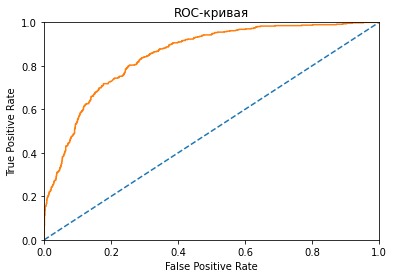

In [85]:
predicted_valid = cat.predict(x_test)

# строим ROC-кривую, считаем AUC-ROC

probabilities_valid = cat.predict_proba(x_test)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(y_test, probabilities_one_valid)

print('AUC-ROC равна', auc_roc)

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid) 
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#### 6. Краткий вывод по работе.

Была проведена предобработка данных, отдельно для моделей без бустинга, и отдельно - для моделей catboost и LGBMClassifier.
Исходные 4 таблицы методом merge были объединены в одну, в обоих случаях, получившиеся пропуски заполнялись отрицательными значениями. Значения для пользователей, зарегистрированных в феврале 2020г были удалены ввиду их незначительного количества (11 человек).

Была попытка создать дополнительный признак на основе данных о дате ухода пользователя: гипотеза состояла в том, что данные будут распределены равномерно, и на их основе можно будет создать признак. Однако данные распределены неравномерно, поэтому признак будет только ухудшать качество обучения.

Проведено масштабирование количественных признаков. 

Пришлось по-разному подойти к процессу кодирования данных: 

    В случае с моделями, которые не могут воспринимать категориальные признаки, пришлось прибегнуть к энкодингу. 

    В случае с градиентным бустингом обошлись простым приведением к категориям. 

В результате, на тренировочной выборке были получены результаты по метрике AUC/ROC-AUC: 

    'DecisionTreeClassifier': 0.8063,
     'LGBMClassifier': 0.8367,
     'RandomForestClassifier': 0.8385,
     'CatBoostClassifier': 0.8448

С небольшим отрывом лучшей моделью стал CatBoostClassifier. 

Данная модель на тестовой выборке показала точность в 0.8511 метрикой AUC-ROC. 

Удаление сильно коррелирующих признаков значительного увеличения точности не дало и из кода удалено. 

#### 7. Отчет о проделанной работе.

В рамках написания прототипа модели машинного обучения, заказчиком были предоставлены 4 таблицы: contract, internet, personal и phone. Данные в самих таблицах предоставлены максимально чистые, пропусков, несоответствующих значений (например, букв вместо цифр) не было. 

Стоит отметить, что количество строк в таблицах не совпадало, что привело к необходимости предобработки на дальнейших этапах. 

По итогу первичного осмотра данных и построения соответствующих графиков, были сделаны следующие выводы и наблюдения: 

1. Для корректной работы необходимо будет объединить 4 таблицы в одну. По плану это объединение происходит через команду merge по столбцу user_id, что было успешно реализовано (параметр how установлен как outer); 

2. Была выдвинута очевидная гипотеза, что, если количество строк не совпадает в некоторых таблицах, на их месте будут образованы пропуски. Данная проблема подтвердилась при объединении и была решена следующим образом: 
        
        По умолчанию было принято, что компания-заказчик однозначно знает, какому user id какой объем услуг оказывается. В связи с этим полученные пропуски можно заполнять "отрицательным" значением (No либо 0 в случае энкодинга), как указание на то, что клиент в любом случае не пользуется той или иной услугой, если его нет в соответствующей таблице с положительным показателем.

В дальнейшем гипотеза подтвердила свою правильность. 

Был составлен следующий план работы с включением ранее озвученных пунктов:

1. Составление единой таблицы признаков через команду merge;
        1.1 Заполнение пропусков через fillna('No') по столбцам где это требуется;
        1.2 Изменение типов данных на категории, чтобы модели могли с ними работать;
        1.3 Работа с другими столбцами - изменение формата дат, удаление дат из столбца EndDate и замена на Yes (чтобы опять же привести к категории). Сюда же, расширенный анализ данных, поиск возможных выбросов по тратам и прочим количественным показателям;
        1.4 Людей, которые зарегистрировались в феврале 2020г - либо удалить, либо заполнить столбец TotalCharges значением из MonthlyCharges - зависит от того, сколько данных есть по этим 11 user ID, если они окажутся полезными - можем использовать в обучении, если по ним нет большого числа признаков - проще удалить; 
        1.5 Проверить корреляцию признаков, есть ли она между признаками;
2. Разделение таблицы на обучающую-валидационную-тестовую выборки и на таблицу признаков-ответов. Целевой показатель - факт ухода клиента.
        2.1 Так как по целевому признаку у нас явный перекос в сторону тех, кто остался, проведем апсемплинг данных чтобы разрыв у положительных-отрицательных "ответов" не был таким большим; если произойдет переобучение - убрать;
        2.2 По итогам поиска корелляции принять решение об удалении каких-то признаков, если такое потребуется; 
3. Метрики качества планирую использовать accuracy_score (для себя) и AUC-ROC (как итоговую метрику). 

При предобработке данных согласно плану:  

1. Реализовано заполнение пропусков отрицательными значениями;
2. Изменены типы данных с числового/объектного на категориальный - позволило сэкономить значительное количество места;
3. Заменены даты в столбце EndDate на положительную категорию Yes/1, что позволило создать корректно работающий целевой признак для будущей модели классификации; пропуски при слиянии таблиц заполнены отрицательными значениями No/0; только в столбце InternetService создана новая категория (столбец описывает тип подключения интернета у клиента и предлагает всего две категории - DSL и оптику - была добавлена третья - отсутствие подключения (No));
4. Так же вышеуказанные даты были вынесены в отдельный датафрейм с целью анализа и возможности выделения в отдельный признак. Не реализовано. 
5. Данные о клиентах, зарегестрированных в феврале 2020 года, не обработаны и удалены. В расчетах не участвуют;
6. Какой-либо высокой корелляции между категориальными признаками быть не может, а именно такие составляют основной массив признаков. Корелляция между оставшимися количественными признаками (ежемесячные расходы и общая сумма расходов, столбцы MonthlyCharges и TotalCharges), очевидна и не была расчитана;
7. Апсемплинг не проводился ввиду высокого качества работы моделей даже с несбалансированными категориями. Данные о качестве работы моделей получали методом кросс-валидации, количество итераций - 10, метрика - roc_auc;
8. Ввиду сжатых сроков проведения работы метрика accuracy_score не была использована, расчет качества обучения велся только на roc_auc метрике. 

В качестве моделей были отобраны следующие: 

1. DecisionTreeClassifier
2. LGBMClassifier
3. RandomForestClassifier
4. CatBoostClassifier

Работа по предобработке данных была разбита на два независимых блока: обработка для моделей без бустинга, где данные кодировались через ordinal encoding и масштабировались stadtartscaler, и обработка для бустинговых моделей, где вместо кодирования данные просто приводились к категориальному типу и так же масштабировались через скалер.

Для каждого блока моделей формировался свой датафрейм (в работе получили названия ds и df соответственно). Некоторая часть предобработки идентична для обоих датафреймов: заполнение пропусков, приведенияе к категориям, удаление стоблца с датой регистрации и user id, изменение типа данных в циферных столбцах (выручка). Различия касались только работы с категориальными признаками.

Обучающие и тестовые выборки формировались для каждого "блока" моделей отдельно. Новые признаки как сказано выше не формировались, но в обучении использовались все признаки, которые были доступны; исследование о возможном увеличении качества работы моделей при удалении некоторых признаков не проводилось. 

Для уравнивания, все модели обучались методом GridSearchCV на своем наборе гиперпараметров, с метрикой качества в параметре scoring roc_auc. Наиболее оптимальные параметры передавались в кросс-валидацию для промежуточного тестирования и определения средней метрики качества roc_auc (число итераций 10). Результаты по всем четырем моделям записывались в специальный словарь, чтобы простым методом сортировки отобрать лучшую модель по завершении обучения и тестирования.

Существенной проблемой стала модель LGBMClassifier, выдающая неизвестную на тот момент ошибку. Решено было с помощью добавления параметров 'bagging_freq' : [1] и 'bagging_fraction': [0.6]. Так же проблемой стала модель catboost, без параметра verbose=False записывающая в лог все итерации обучения модели (этап fit), что приводило к существенному росту размера файла. Обе проблемы решены, соответствующие комментарии оставлены в коде. 

Наилучшее значение метрики auc удалось получить на модели catboost, причем не последнюю роль оказал параметр learning_rate, благодаря ему удалось получить итоговую метрику на тестовой выборке выше 0.85. 

Детальное описание модели, выбранной в качестве итоговой: 

CatBoostClassifier, parameters ={'depth': 2, 'learning_rate': 0.02, 'n_estimators': 1100, 'eval_metric': 'AUC'}.

Итоговая точность работы модели на тестовой выборке: 0.8512